In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seawater as sw
import pandas as pd

/tmp/ipykernel_343335/1558162435.py:5: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
data = xr.open_dataset("757.nc")
data

<xarray.Dataset>
Dimensions:      (depth: 74, latitude: 101, longitude: 121, time: 360)
Coordinates:
  * depth        (depth) float32 0.5058 1.556 2.668 ... 5.495e+03 5.698e+03
  * latitude     (latitude) float32 20.0 20.25 20.5 20.75 ... 44.5 44.75 45.0
  * longitude    (longitude) float32 120.0 120.2 120.5 ... 149.5 149.8 150.0
  * time         (time) datetime64[ns] 1993-01-01 1993-02-01 ... 2022-12-01
Data variables:
    thetao_glor  (time, depth, latitude, longitude) float32 ...
    so_glor      (time, depth, latitude, longitude) float32 ...
Attributes:
    references:                http://marine.copernicus.eu
    credit:                    E.U. Copernicus Marine Service Information (CM...
    title:                     Monthly mean fields for product GLOBAL_MULTIYE...
    history:                   Creation 2023-October-31 12:46:42 GMT+0200
    Conventions:               CF-1.6
    institution:               Mercator Ocean
    contact:                   servicedesk.cmems@mercator-ocean.eu
    source:                    Copernicus Marine Service
    producer:                  CMEMS - Global Monitoring and Forecasting Centre
    copernicusmarine_version:  2.0.1

In [3]:
T = data['thetao_glor']  # Temperature
S = data['so_glor']  #sal

In [4]:
lat = data['latitude']
lon = data['longitude']

In [5]:
import pandas as pd

# Get the spatial shape
ntime,ndepth, nlat, nlon = T.shape

# Convert time to months
time_months = pd.to_datetime(T['time'].values).month

# Broadcast months into a 3D array
month_array = np.broadcast_to(np.array(time_months)[:, np.newaxis, np.newaxis], (ntime, nlat, nlon))

# Now flatten all three arrays equally
T_mean = T.mean(dim=['latitude', 'longitude'])  # (time, depth)
S_mean = S.mean(dim=['latitude', 'longitude'])  # (time, depth)

months = pd.to_datetime(T['time'].values).month
ntime, ndepth = T_mean.shape

# # Clean NaNs (same mask for all)
# mask = ~np.isnan(T_flat) & ~np.isnan(S_flat)
# T_flat = T_flat[mask]
# S_flat = S_flat[mask]
# months = months[mask]

In [6]:
years = pd.to_datetime(T['time'].values).year


In [7]:
T_mean = T.mean(dim=['latitude', 'longitude']) 
T.shape

(360, 74, 101, 121)

In [8]:
from matplotlib.cm import get_cmap
import calendar


/tmp/ipykernel_343335/2961396588.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("tab20", 12)


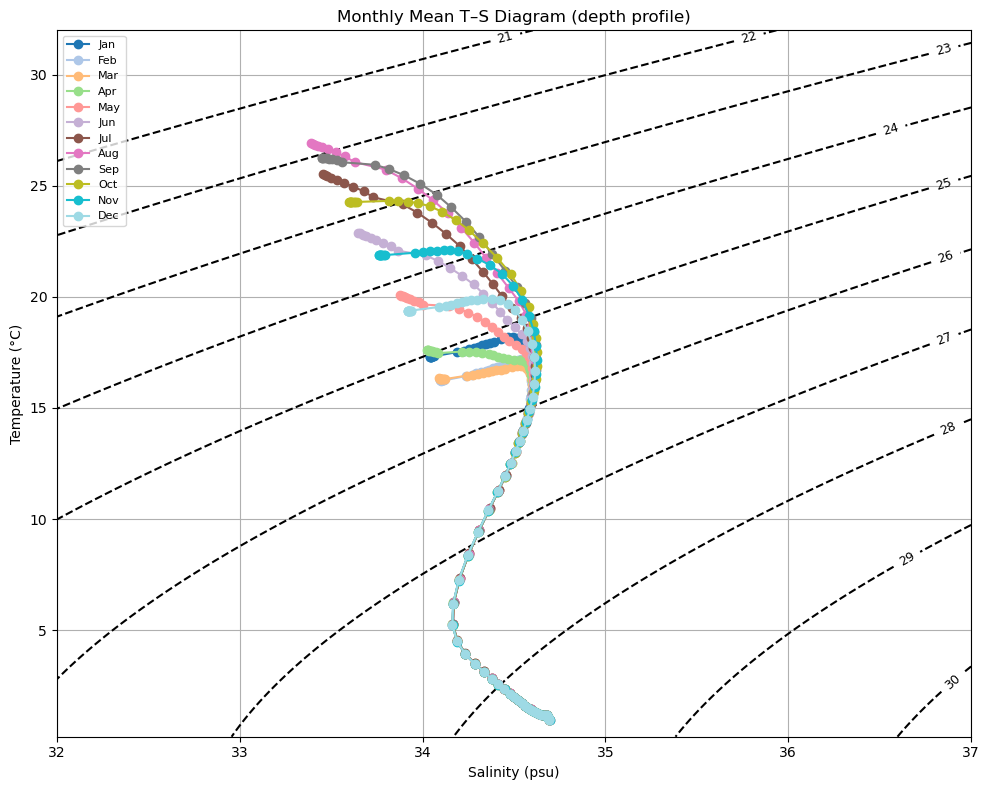

In [9]:


# --- Compute Sigma-t using EOS-80 approximation ---
def sigma_t_approx(S, T):
    rho_w = (999.842594 + 6.793952e-2*T - 9.09529e-3*T**2 +
             1.001685e-4*T**3 - 1.120083e-6*T**4 + 6.536332e-9*T**5)
    A = (0.824493 - 4.0899e-3*T + 7.6438e-5*T**2 -
         8.2467e-7*T**3 + 5.3875e-9*T**4)
    return rho_w + A * S - 1000

sigma_vals = sigma_t_approx(S_mean, T_mean)

# --- Plotting T–S Diagram ---
plt.figure(figsize=(10, 8))

# Contour background (sigma-t)
s_range = np.linspace(32, 37, 200)
t_range = np.linspace(0.2, 32, 200)
S_grid, T_grid = np.meshgrid(s_range, t_range)
sigma_grid = sigma_t_approx(S_grid, T_grid)

cs = plt.contour(S_grid, T_grid, sigma_grid, levels=[21, 22, 23, 24, 25, 26, 27, 28,29,30],
                 colors='k', linestyles='--')
plt.clabel(cs, inline=True, fontsize=9, fmt="%.0f")
cmap = get_cmap("tab20", 12)
for m in range(1, 13):
    idx = np.where(months == m)[0]
    if len(idx) == 0:
        continue
    T_month = T_mean[idx, :].mean(axis=0)  # shape: depth
    S_month = S_mean[idx, :].mean(axis=0)
    plt.plot(S_month, T_month, marker='o', label=calendar.month_abbr[m], color=cmap(m-1))

plt.xlabel("Salinity (psu)")
plt.ylabel("Temperature (°C)")
plt.title("Monthly Mean T–S Diagram (depth profile)")
plt.legend(loc='best', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_343335/2095799187.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap("viridis", len(unique_years))


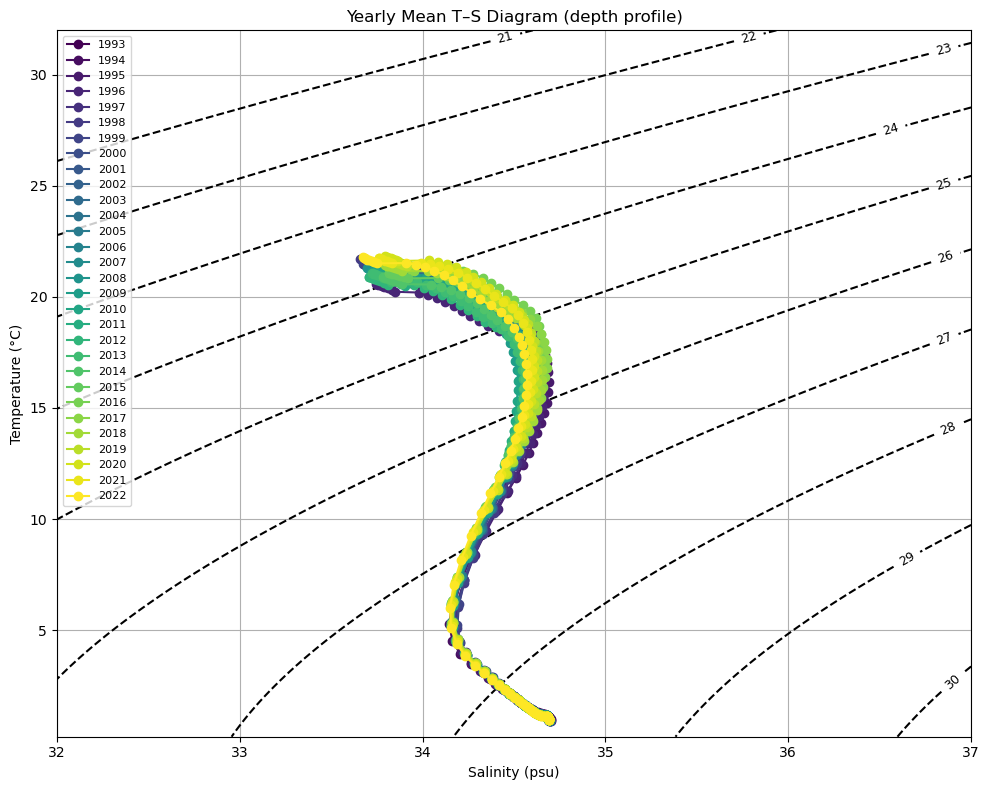

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.cm import get_cmap

# --- Compute Sigma-t using EOS-80 approximation ---
def sigma_t_approx(S, T):
    rho_w = (999.842594 + 6.793952e-2*T - 9.09529e-3*T**2 +
             1.001685e-4*T**3 - 1.120083e-6*T**4 + 6.536332e-9*T**5)
    A = (0.824493 - 4.0899e-3*T + 7.6438e-5*T**2 -
         8.2467e-7*T**3 + 5.3875e-9*T**4)
    return rho_w + A * S - 1000

sigma_vals = sigma_t_approx(S_mean, T_mean)

# --- Plotting T–S Diagram ---
plt.figure(figsize=(10, 8))

# Contour background (sigma-t)
s_range = np.linspace(32, 37, 200)
t_range = np.linspace(0.2, 32, 200)
S_grid, T_grid = np.meshgrid(s_range, t_range)
sigma_grid = sigma_t_approx(S_grid, T_grid)

cs = plt.contour(S_grid, T_grid, sigma_grid, levels=[21, 22, 23, 24, 25, 26, 27, 28, 29, 30],
                 colors='k', linestyles='--')
plt.clabel(cs, inline=True, fontsize=9, fmt="%.0f")

# Prepare colormap for years
unique_years = np.unique(years)
cmap = get_cmap("viridis", len(unique_years))

# Loop through each year
for i, y in enumerate(unique_years):
    idx = np.where(years == y)[0]
    if len(idx) == 0:
        continue
    T_year = T_mean[idx, :].mean(axis=0)  # average over days of that year
    S_year = S_mean[idx, :].mean(axis=0)
    plt.plot(S_year, T_year, marker='o', label=str(y), color=cmap(i))

plt.xlabel("Salinity (psu)")
plt.ylabel("Temperature (°C)")
plt.title("Yearly Mean T–S Diagram (depth profile)")
plt.legend(loc='best', fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
np.where(years == 2018)

(array([300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311]),)

## EKE

In [12]:
import xarray as xr
import numpy as np

# Load daily SLA data
ds_daily = xr.open_dataset("wokslh.nc")
sla = ds_daily['zos_glor']  # Assuming 'zos_glor' is the variable name

# Constants
g = 9.81
Omega = 7.2921e-5
lat = sla.latitude
lon = sla.longitude

# Calculate Coriolis parameter
f = 2 * Omega * np.sin(np.deg2rad(lat))
f = f.where(f != 0, np.nan)  # Avoid division by zero at equator

# Convert degree distances to meters
dx = 111000 * np.cos(np.deg2rad(lat))  # m/deg for longitude
dy = 111000  # m/deg for latitude

# Compute gradients (SLA derivatives)
dSLA_dx = sla.differentiate("longitude") / dx
dSLA_dy = sla.differentiate("latitude") / dy

# Geostrophic velocities
Ug = -g * dSLA_dy / f
Vg = g * dSLA_dx / f


In [ ]:
dy

In [ ]:
climug = Ug.groupby('time.month').mean(dim = 'time')
climvg = Vg.groupby('time.month').mean(dim = 'time')

In [ ]:
ug_pr = climug-Ug.groupby('time.month')

In [ ]:
# ug_pr = [(climug.isel(month = i)-Ug.groupby('time.month')[i]).mean(dim=["latitude", "longitude"]) for i in range(1,12)]
ug_pr_xr = ug_pr**2
# ug_pr_mean = ug_pr_xr.groupby('time.year').mean(dim = 'time')


In [ ]:
vg_pr = climvg-Vg.groupby('time.month')

In [ ]:

vg_pr_xr = vg_pr**2
# vg_pr_mean = vg_pr_xr.groupby('time.year').mean(dim = 'time')


In [21]:
# import matplotlib.pyplot as plt
# ug_pr_xr = xr.concat(ug_pr,dim = 'time')
# # plt.plot(ug_pr_xr['time'].values,ug_pr_xr.values)
# ug_pr_mean = ug_pr_xr.groupby('time.year').mean(dim = 'time')
# plt.plot(ug_pr_mean['year'].values,ug_pr_mean.values)
